# Simulating optical neural networks with _neuroptica_

In [1]:
import sys
sys.path.append("../neuroptica") # I'm using my local development neuroptica package

import time

import neuroptica as neu
import numpy as np

import cProfile

import scipy
import matplotlib.pyplot as plt

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

## Photonic Network Demonstration

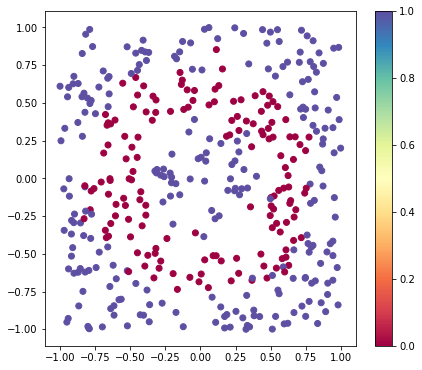

In [2]:
X, Y = neu.utils.generate_ring_planar_dataset()
# X, Y = neu.utils.generate_diagonal_planar_dataset()
# X, Y = neu.utils.generate_separable_planar_dataset()

labels = np.array([0 if yi[0] > yi[1] else 1 for yi in Y]).flatten()
plt.figure(figsize=(6,6))
plt.scatter((X.T)[0, :], (X.T)[1, :], c=labels, cmap=plt.cm.Spectral)
plt.colorbar()
plt.show()

In [3]:
def plot_planar_boundary(X, Y, model, grid_points=20, P0=10):
    '''
    Plots the decision boundary for a model predicting planar datasets
    :param X: shape (n_features, n_samples), first two features are x, y coordinates
    :param Y: true labeles, (n_features, n_samples)
    :param model: a neuroptica model
    :param grid_points: number of grid points to render
    :return:
    '''
    x_min, y_min = np.min(X, axis=1)[0:2]
    x_max, y_max = np.max(X, axis=1)[0:2]
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid_points), np.linspace(x_min, x_max, grid_points))

    # Predict the function value for the whole grid
    N = model.layers[0].input_size
    inputs = []
    for x, y in zip(xx.flatten(), yy.flatten()):
        sample = np.zeros(N)
        sample[0] = x
        sample[1] = y
        sample[2] = np.sqrt(P0 - np.sum(sample**2))
        inputs.append(sample)
    inputs = np.array(inputs).T

    Y_hat = model.forward_pass(inputs).T
    Y_hat = [(0 if yhat[0] > yhat[1] else 1) for yhat in Y_hat]
    Z = np.array(Y_hat)
    Z = Z.reshape(xx.shape)

    # Plot the contour and training examples
    plt.figure(figsize=(6, 6))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
#     plt.colorbar()

    points_x = X[0,:]
    points_y = X[1,:]
    labels = np.array([0 if yi[0] > yi[1] else 1 for yi in np.abs(Y.T)]).flatten()

    plt.ylabel('x2')
    plt.xlabel('x1')

    plt.xlim([x_min, x_max])
    plt.ylim([y_min, y_max])

    plt.scatter(points_x, points_y, c=labels, cmap=plt.cm.Spectral)
    plt.colorbar()
    plt.show()

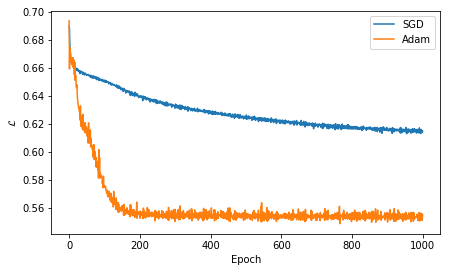

In [8]:
all_losses = []

for k in range(2):
    N = 4
    model = neu.Sequential([
        neu.ClementsLayer(N),
        neu.Activation(neu.Abs(N)),
        neu.ClementsLayer(N),
        neu.Activation(neu.Abs(N)),
        neu.ClementsLayer(N),
        neu.Activation(neu.Abs(N)),
        neu.ClementsLayer(N),
        neu.Activation(neu.Abs(N)),
        neu.ClementsLayer(N),
        neu.Activation(neu.Abs(N)),
        neu.ClementsLayer(N),
        neu.Activation(neu.AbsSquared(N)),
        neu.DropMask(N, keep_ports=[0,1])
    ])

    P0 = 10
    X_formatted = np.array(np.pad(X, ((0,0),(0,2)), mode="constant"))
    for i, x in enumerate(X_formatted):
        X_formatted[i][2] = np.sqrt(P0 - np.sum(x**2))
    X_formatted = X_formatted.T
    Y_formatted = Y.T

    optimizers = [neu.InSituGradientDescent(model, neu.CategoricalCrossEntropy, learning_rate=0.005),
                  neu.InSituAdam(model, neu.CategoricalCrossEntropy, step_size=0.005)]
    
    losses = optimizers[k].fit(X_formatted, Y_formatted, epochs=1000, batch_size=32)
    all_losses.append(losses)
    
sgd_loss, adam_loss = all_losses

plt.plot(sgd_loss, label="SGD")
plt.plot(adam_loss, label="Adam")
plt.xlabel("Epoch")
plt.ylabel("$\mathcal{L}$")
plt.legend()
plt.show()

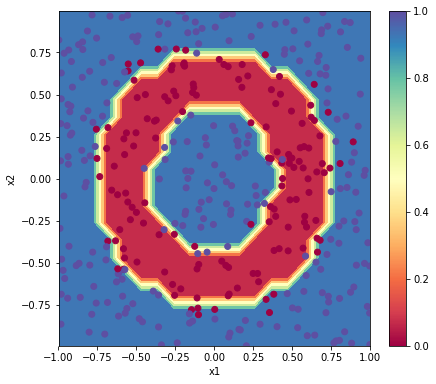

In [9]:
plot_planar_boundary(X_formatted, Y_formatted, model)

## Electro-optic activation model

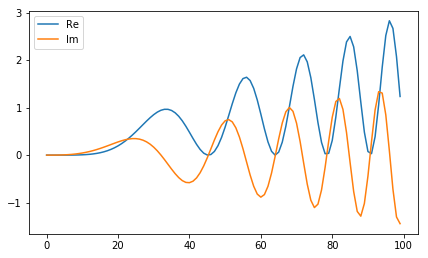

In [16]:
eo_settings = { 'power_tapped':      0.05,
                'responsivity':      0.80,
                'mode_area':         1.00,
                'modulator_voltage': 10.0,
                'bias_voltage':      10.0,
                'resistance':        2e5 }

actEO = neu.ElectroOpticActivation(1, **eo_settings)

x = np.linspace(0,3,100)
plt.plot(np.real(actEO.forward_pass(x)),label="Re")
plt.plot(np.imag(actEO.forward_pass(x)),label="Im")
plt.legend()
plt.show()

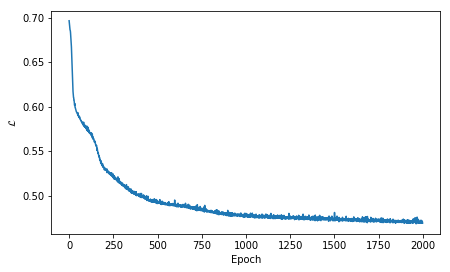

In [14]:
N = 4
mask = 10.0 * np.ones(N)

model = neu.Sequential([
    neu.ClementsLayer(N),
    neu.Activation(neu.ElectroOpticActivation(N, **eo_settings)),
    neu.ClementsLayer(N),
    neu.Activation(neu.ElectroOpticActivation(N, **eo_settings)),
    neu.ClementsLayer(N),
    neu.Activation(neu.ElectroOpticActivation(N, **eo_settings)),
    neu.ClementsLayer(N),
    neu.Activation(neu.AbsSquared(N)),
    neu.DropMask(N, keep_ports=[0,1])
])

P0 = 3
X_formatted = np.array(np.pad(X, ((0,0),(0,N-2)), mode="constant"))
for i, x in enumerate(X_formatted):
    X_formatted[i][2] = np.sqrt(P0 - np.sum(x**2))
X_formatted = X_formatted.T
Y_formatted = Y.T

# opt = neu.InSituGradientDescent(model, neu.CategoricalCrossEntropy, learning_rate=0.005)
opt = neu.InSituAdam(model, neu.CategoricalCrossEntropy, step_size=0.002)
losses = opt.fit(X_formatted, Y_formatted, epochs=2000, batch_size=50)
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("$\mathcal{L}$")
plt.show()

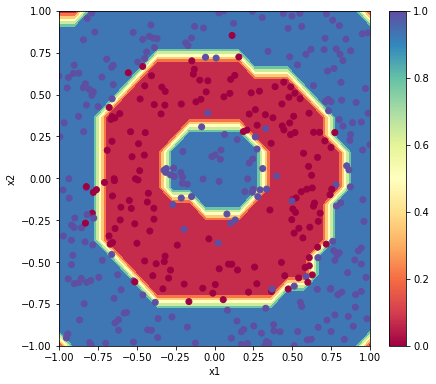

In [15]:
plot_planar_boundary(X_formatted, Y_formatted, model, P0=P0)

## Profiling

In [4]:
N = 4
model = neu.Sequential([
    neu.ClementsLayer(N),
    neu.Activation(neu.Abs(N)),
    neu.ClementsLayer(N),
    neu.Activation(neu.Abs(N)),
    neu.ClementsLayer(N),
    neu.Activation(neu.Abs(N)),
    neu.ClementsLayer(N),
    neu.Activation(neu.Abs(N)),
    neu.ClementsLayer(N),
    neu.Activation(neu.Abs(N)),
    neu.ClementsLayer(N),
    neu.Activation(neu.AbsSquared(N)),
    neu.DropMask(N, keep_ports=[0,1])
])

P0 = 10
X_formatted = np.array(np.pad(X, ((0,0),(0,2)), mode="constant"))
for i, x in enumerate(X_formatted):
    X_formatted[i][2] = np.sqrt(P0 - np.sum(x**2))
X_formatted = X_formatted.T
Y_formatted = Y.T

opt = neu.InSituGradientDescent(model, neu.CategoricalCrossEntropy, learning_rate=0.005)
# opt = neu.InSituAdam(model, neu.CategoricalCrossEntropy, step_size=0.005)

cProfile.run('opt.fit(X_formatted, Y_formatted, epochs=250, batch_size=32)', sort='cumulative')


         13906073 function calls (13896816 primitive calls) in 30.816 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      2/1    0.000    0.000   30.816   30.816 {built-in method builtins.exec}
        1    0.000    0.000   30.816   30.816 <string>:1(<module>)
        1    0.209    0.209   30.816   30.816 optimizers.py:56(fit)
    19500    1.503    0.000   23.300    0.001 component_layers.py:306(adjoint_optimize)
   156000    2.992    0.000   10.086    0.000 component_layers.py:77(get_partial_transfer_matrices)
    19500    0.545    0.000    9.531    0.000 component_layers.py:228(compute_phase_shifter_fields)
    19500    0.575    0.000    9.037    0.000 component_layers.py:266(compute_adjoint_phase_shifter_fields)
   312000    1.221    0.000    8.388    0.000 component_layers.py:66(get_transfer_matrix)
   468000    4.818    0.000    6.103    0.000 components.py:87(get_transfer_matrix)
    39000    0.072    0.000    5.